Month_data 是價格動能因子，使用的是收盤價靠近52週新高的比率

In [ ]:
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import numpy as np
import math


sqlite_file = "/Users/tzuyuan/DATA/stock.db"
conn = sqlite3.connect(sqlite_file)
cursor = conn.cursor()

# 數據處理
path = '/Users/tzuyuan/DATA'
month_data = "monthly_data.csv"
file_path = os.path.join(path, month_data)

# 52 week high etc...
month_data = pd.read_csv(file_path,encoding = 'utf-8')
month_data.drop(columns = 'Unnamed: 0', inplace = True)
pd.to_datetime(month_data['date'], format = "%Y-%m")
month_data.sort_values(by=['ticker','date'],inplace=True)
month_data.set_index(['date','ticker'], inplace=True)
year_high = month_data[['6_month_ratio','12_month_ratio']].copy()
year_high['6_rank'] = pd.qcut(year_high['6_month_ratio'], 10, labels=False)
year_high['12_rank'] = pd.qcut(year_high['12_month_ratio'], 10, labels=False)

year_high.reset_index(inplace=True)
year_high['ticker'] = year_high['ticker'].astype(str)


# 本益比
query = """

SELECT
    `date`,
    `ticker`,
    `本益比(近四季)`,
    `股價淨值比`

FROM
    backtest_dataset_t14
WHERE
    LENGTH(ticker) <= 4
    AND ticker NOT LIKE '0%'
    AND ticker GLOB '*[0-9]'
"""
df_pe = pd.read_sql_query(query,conn) 
df_pe['date'] = pd.to_datetime(df_pe['date'])

df_pe['pe_below_25'] = np.where((df_pe['本益比(近四季)'] < 25) & (df_pe['本益比(近四季)'] > 8 ),1, 0)

df_pe = df_pe.set_index(['date','ticker'])
df_pe= df_pe.loc[df_pe.index.get_level_values('date') >= '2011-01-01']



In [3]:
# 外資買賣超金額

query1 = """

SELECT
    `date`,
    `ticker`,
    `外資買金額(千)`,
    `外資賣金額(千)`,
    `外資持股比率_百分比`,
    (COALESCE(`外資買金額(千)`, 0) - COALESCE(`外資賣金額(千)`, 0)) AS `net_buy(thousand)`,
    (COALESCE(`外資買金額(千)`, 0) / COALESCE(`外資賣金額(千)`, 0)) AS `buy_sell_ratio`
FROM
    backtest_dataset_t2
WHERE
    LENGTH(ticker) <= 4
    AND ticker NOT LIKE '0%'
    AND ticker GLOB '*[0-9]'
"""

n_20 = 20
n_40 = 40
n_60 = 60

df_foreign = pd.read_sql_query(query1, conn)
df_foreign['date'] = pd.to_datetime(df_foreign['date'])

df_foreign['is_net_buy'] = df_foreign['net_buy(thousand)'] > 0
df_foreign['is_net_buy'] = df_foreign['is_net_buy'].astype(int)

# 計算過去 30 天內的 1 的個數
df_foreign['net_buy_count_60d'] = df_foreign.groupby('ticker')['is_net_buy'].rolling(window=60, min_periods=20).sum().reset_index(0, drop=True)
# 將其轉換為比例
df_foreign['net_buy_ratio_60d'] = df_foreign['net_buy_count_60d'] / 60
df_foreign['ratio_rank'] = pd.qcut(df_foreign['net_buy_ratio_60d'], 10, labels=False)

df_foreign['buy_sell_ratio'] = df_foreign['buy_sell_ratio'].fillna(0)


df_foreign['20_day_ratio'] = df_foreign.groupby('ticker')['buy_sell_ratio'].rolling(window=n_40, min_periods=5).mean().reset_index(0, drop=True)
df_foreign['20_std_ratio'] = df_foreign.groupby('ticker')['buy_sell_ratio'].rolling(window=n_40, min_periods=5).std().reset_index(0, drop=True)
df_foreign['20_Nratio'] = df_foreign['20_day_ratio'] / df_foreign['20_std_ratio']
df_foreign['20_Nratio'] = df_foreign['20_Nratio'].fillna(0)


df_foreign['PositiveNetBuySell'] = df_foreign['net_buy(thousand)'] > 0

df_foreign['Group'] = df_foreign.groupby('ticker')['PositiveNetBuySell'].transform(lambda x: (x > 0).astype(int).diff().fillna(0).ne(0).cumsum())

# 計算連續天數，只針對買超（PositiveNetBuySell > 0）
df_foreign['ConsecutiveBuyDays'] = df_foreign.groupby(['ticker', 'Group']).cumcount() + 1
df_foreign['ConsecutiveBuyDays'] = df_foreign['ConsecutiveBuyDays'] * (df_foreign['PositiveNetBuySell'] > 0)

# 計算過去30天內連續買超的最大天數
df_foreign['MaxConsecutiveBuyDays30'] = df_foreign.groupby('ticker')['ConsecutiveBuyDays'].rolling(window=30, min_periods=1).max().reset_index(level=0, drop=True)
df_foreign['holding_ratio'] = np.where((df_foreign['外資持股比率_百分比'] > 20), 1, 0)
df_foreign.set_index(['date','ticker'], inplace=True)

In [8]:
# 處理return 數據

sqlite_file = "/Users/tzuyuan/DATA/stock.db"
conn = sqlite3.connect(sqlite_file)
cursor = conn.cursor()

query2 = """
SELECT
    `date`,
    `ticker`,
    `開盤價`,
    `最高價`,
    `最低價`,
    `收盤價`
FROM
    `backtest_dataset_t13`
WHERE
    LENGTH(ticker) <= 4
    AND ticker NOT LIKE '0%'
    AND ticker GLOB '*[0-9]'

"""

stock = pd.read_sql_query(query2, con = conn)
stock['return'] = stock.groupby('ticker')['收盤價'].pct_change(1)

stock['date'] = pd.to_datetime(stock['date'])


stock['month'] = stock['date'].dt.month  # 提取月份

stock.rename(columns={"開盤價":"Open", "最高價":"High", "最低價":"Low", "收盤價":"Close"}, inplace=True)
stock = stock[stock['date'] > '2011-01-31']

stock['month'] = stock['date'].dt.to_period("M")
stock['month'] = stock['month'].astype(str)
stock['quarter'] = stock['date'].dt.to_period("Q")
stock['quarter'] = stock['quarter'].astype(str)

處理指標跟數據

In [9]:
query3 = """

SELECT
    `date`,
    `ticker`,
    `month`,
    `開盤價`,
    `最高價`,
    `最低價`,
    `收盤價`,
    `成交金額(千)`,
    `週轉率_百分比`,
    `本益比`,
    `is_first_of_month`,
    `previous`,
    `return`
FROM
    `stock_price`
WHERE
    LENGTH(ticker) <= 4
    AND ticker NOT LIKE '0%'
    AND ticker GLOB '*[0-9]'
"""

df = pd.read_sql_query(query3, con=conn)
df['date'] = pd.to_datetime(df['date'])
df.set_index(['date','ticker'], inplace=True)

# 製作atr and turnover 指標
df_merge = df.merge(df_foreign, left_index=True, right_index=True)
df_merge = df_merge.merge(df_pe, left_index=True, right_index=True)

df_merge['turnover_mean'] = df_merge.groupby(level=1)['週轉率_百分比'].rolling(n_60, min_periods=10).mean().reset_index(level=0, drop=True)
df_merge['turnover_std'] = df_merge.groupby(level=1)['週轉率_百分比'].rolling(n_60, min_periods=10).std().reset_index(level=0, drop=True)
df_merge['z_turnover'] = (df_merge['週轉率_百分比'] - df_merge['turnover_mean'])/df_merge['turnover_std']
df_merge = df_merge.loc[df_merge.index.get_level_values('date') >= '2011-01-01']

df_atr = pd.DataFrame()
df_atr = df_merge[['month']].copy()
df_atr['tr1'] = df_merge['最高價'] - df_merge['最低價']
df_atr['tr2'] = (df_merge['最高價'] - df_merge['previous']).abs()
df_atr['tr3'] = (df_merge['最低價'] - df_merge['previous']).abs()
df_atr['tr'] = df_atr[['tr1', 'tr2', 'tr3']].max(axis=1)


df_atr['atr'] = df_atr['tr'].rolling(window=n_60, min_periods=1).mean()
df_atr['NATR'] = (df_atr['atr']/df_merge['收盤價']) * 100
df_atr = df_atr.loc[df_atr.index.get_level_values('date') >= '2011-01-01']


In [10]:
query4 = """

SELECT
    `date`,
    `ticker`,
    `收盤價`
FROM
    backtest_dataset_t6
"""

df_vix = pd.read_sql_query(query4, conn)
df_vix['date'] = pd.to_datetime(df_vix['date'])
df_vix = df_vix[df_vix['ticker'] == 'VIX15']
df_vix['20_mean'] = df_vix['收盤價'].rolling(window=20, min_periods=10).mean()
df_vix['60_mean'] = df_vix['收盤價'].rolling(window=60, min_periods=10).mean()
df_vix['20_bigger_60'] = np.where((df_vix['20_mean']-df_vix['60_mean']) < 0, 1, 0) # 恐慌較小的時段為1
df_vix['month'] = df_vix['date'].dt.to_period("M")
df_vix = df_vix.groupby('month').tail(1).reset_index(drop=True)
df_vix = df_vix[df_vix['month'] >= '2011-01']
df_vix.drop(columns='date',inplace=True)
df_vix.rename(columns={"month":'date'},inplace=True)
df_vix['date'] = df_vix['date'].astype(str)

In [11]:
# 特徵排名function 
# 給定dataframe 及特徵

def qcut_feature(data, data_name='fundamental_features:ROE稅後', q_range=10, ascending=True):

    rank_df = (data[data_name]
               .groupby(level = 'date')
               .rank(pct=True, ascending=ascending)
               .mul(q_range)
               .add(1)
               .apply(np.floor).clip(0,q_range))

    return rank_df

buy_sell_ratio_20_rank = qcut_feature(df_merge, data_name = 'ratio_rank')
z_turnover_rank = qcut_feature(df_merge, data_name='z_turnover', ascending=False)
natr_rank = qcut_feature(df_atr, data_name="NATR", ascending=False)
con_buy = qcut_feature(df_merge, data_name = 'ConsecutiveBuyDays')
pe_rank = qcut_feature(df_merge,data_name='本益比(近四季)', ascending=False)
holding_ratio = qcut_feature(df_merge, data_name='holding_ratio')

In [12]:
# turn into score_df

a = natr_rank.unstack().fillna(0)
b = z_turnover_rank.unstack().fillna(0)
c = buy_sell_ratio_20_rank.unstack().fillna(0) 
d = df_merge.unstack()['pe_below_25']
e = con_buy.unstack()
f = holding_ratio.unstack()
g = pe_rank.unstack()
z = [a,b,c,d,e,f,g]

result_dic = {}

for i in range(len(z)):
    k = z[i].unstack()
    k = k.reset_index()
    k['month'] = k['date'].dt.to_period("M")
    month_k = k.groupby(['month','ticker']).tail(1).reset_index(drop=True)
    result_dic[i] = month_k

key_mapping = {0 : 'natr_rank', 
               1 : 'turnover_rank', 
               2 : 'rank_buy_sell_ratio', 
               3 : "pe_below_20", 
               4 : "MaxConsecutiveDays30",
               5 : "holding_ratio",
               6 : 'pe_rank'
               }

new_dict = {key_mapping.get(k, k): v for k, v in result_dic.items()}

for key, df1 in new_dict.items():
    df1.drop(columns = 'date', inplace=True)
    df1.rename(columns = {0:key, 'month':'date'}, inplace=True)
    df1.set_index(['date','ticker'], inplace=True)

# 假設字典中有三個 DataFrame
merged_df = pd.concat([new_dict['rank_buy_sell_ratio'], 
                       new_dict['turnover_rank'], 
                       new_dict['natr_rank'], 
                       new_dict['pe_below_20'], 
                       new_dict['MaxConsecutiveDays30'],
                       new_dict['holding_ratio'],
                       new_dict['pe_rank']
                       ], 
                       axis=1)
merged_df.reset_index(inplace=True)
merged_df['date'] = merged_df['date'].astype(str)
merged_df['ticker'] = merged_df['ticker'].astype(str)
score_df = pd.merge(year_high, merged_df, on=['date','ticker'], how='left')
score_df = pd.merge(score_df, df_vix[['date','20_bigger_60']], on = 'date', how = 'left')

對照組

In [13]:
#對照組合回測績效
# 定義購買規則
def assign_portfolio(row):
    if row['ticker'] == '2330':
        return 1



# 應用購買規則來創建 portfolio 欄位
stock['portfolio'] = stock.apply(assign_portfolio, axis=1)
stock.set_index(['date','ticker'], inplace = True)
stock_return = stock.unstack()['return']
stock_portfolio = stock.unstack()['portfolio']

test_return = stock_return * stock_portfolio
stock.reset_index(inplace=True)


In [14]:

aa = 0.5
bb = 0.5
cc = 0

score_df = score_df[score_df['pe_below_20'] == 1]


score_df['foreign_weighted_score'] = (
    
    score_df['MaxConsecutiveDays30'] * 1 +  
    score_df['rank_buy_sell_ratio'] * 0
)

score_df['12_weighted_score'] = (

    score_df['12_rank'] * aa +
    score_df['pe_rank'] * bb +
    score_df['foreign_weighted_score'] * cc
)

score_df['6_weighted_score'] = (

    score_df['6_rank'] * aa +  
    score_df['pe_below_20'] * bb

)

score_df['mix_pe_holding'] = (

    score_df['pe_rank'] * 0.5 +
    score_df['holding_ratio'] * 0.5
)

In [15]:
# choose portfolio 

def split_into_groups(df_list, group_num, indicator_list):
    
    result_dict = {}

    # 將所有分組資料整合成一個 DataFrame
    combined_df = pd.concat([group for _, group in df_list])

    for category in indicator_list:
        # 定義分組邊界
        bins = [-float('inf'), 6, float('inf')]

        combined_df[f"{category}_group"] = pd.cut(combined_df[category],
                                                  bins=bins,
                                                  labels=False
                                                  ) + 1
        # 根據分組結果將資料存入字典中
        for num in range(1, group_num + 1):
            group_key = f"{category}_group_{num}"
            result_dict[group_key] = combined_df[combined_df[f'{category}_group'] == num]

    return result_dict

def rank_top_n(result_dict, n , columns):
    
    for key, df in result_dict.items():
        df['in_portfolio'] = None

        rank_df = df.groupby('date', group_keys=False).apply(
            lambda x: x.sort_values(columns, ascending = False).head(n)
            )

        df.loc[rank_df.index, f'{key}_in_portfolio'] = 1
        result_dict[key] = df[['date', 'ticker', f'{key}_in_portfolio']].reset_index(drop=True)
    return result_dict

def merge_result_dict(result_dict):
    merged_df = next(iter(result_dict.values()))

    # Merge all DataFrames in the dictionary on ['date', 'ticker']
    for _, df in list(result_dict.items())[1:]:
        merged_df = pd.merge(merged_df, df, on=['date', 'ticker'], how='outer')

    return merged_df

In [ ]:
#選股標準

group_df = score_df.groupby("date")
group_num = 2
stock_num = 30
indicator_list = [ 'natr_rank',
                   'turnover_rank', 
                   'rank_buy_sell_ratio', 
                   "pe_rank", 
                   "MaxConsecutiveDays30", 
                   "holding_ratio",
                   'mix_pe_holding'
]

sorted_column = ['6_weighted_score','12_weighted_score']
result_dict_ = split_into_groups(group_df, group_num, indicator_list)
result_dict_['total'] = score_df
result_dict = rank_top_n(result_dict_, stock_num, sorted_column[1])

portfolio_df = merge_result_dict(result_dict)
portfolio_df['date'] = pd.to_datetime(portfolio_df['date'])




將選股名單跟return表格整理在一起

In [17]:
#月度換倉資料處理

portfolio_df['month'] = portfolio_df['date'].dt.to_period("M")
portfolio_df['quarter'] = portfolio_df['date'].dt.to_period("Q")
portfolio_df['month'] = portfolio_df['month'] + 1
portfolio_df = portfolio_df[portfolio_df['month'] < pd.Period('2023-01', freq='M')]
portfolio_df['month'] = portfolio_df['month'].astype(str)
portfolio_df = portfolio_df.drop(columns='date')
month_df = pd.merge(stock[['date','ticker','return','month']], portfolio_df, on=['month', 'ticker'], how='left')
month_df.reset_index(drop=True, inplace=True)
month_df.set_index(['date','ticker'], inplace=True)

# quarter 換倉位

quarter_portfolio = portfolio_df.groupby(['quarter','ticker']).tail(1).reset_index(drop=True)
quarter_portfolio['quarter'] = quarter_portfolio['quarter'] + 1
quarter_portfolio = quarter_portfolio[quarter_portfolio['quarter'] < pd.Period("2023Q1",freq="Q")]
quarter_portfolio['quarter'] = quarter_portfolio['quarter'].astype(str)
quarter_df = pd.merge(stock[['date','ticker','return','quarter']], quarter_portfolio, on=['quarter','ticker'], how='left')
quarter_df = quarter_df[quarter_df['date'] >= '2011-04']
quarter_df.reset_index(drop=True, inplace=True)
quarter_df.set_index(['date', 'ticker'],inplace=True)


In [18]:
# backtest scheme 
# cost estimated

group_list =  ['total_in_portfolio',
                #'natr_rank_group_1_in_portfolio',
                #'natr_rank_group_2_in_portfolio',
                #'turnover_rank_group_1_in_portfolio',
                #'turnover_rank_group_2_in_portfolio',
                #'MaxConsecutiveDays30_group_1_in_portfolio',
                #'MaxConsecutiveDays30_group_2_in_portfolio',
                'holding_ratio_group_1_in_portfolio',
                'holding_ratio_group_2_in_portfolio',
                'pe_rank_group_1_in_portfolio',
                'pe_rank_group_2_in_portfolio',
                #'mix_pe_holding_group_1_in_portfolio',
                #'mix_pe_holding_group_2_in_portfolio'
]

test = portfolio_df.set_index(['month','ticker']) # 只要丟portfolio表格進去就可以得到該月總共買賣幾次

def cost_estimate(test, group_list):
    turnover_times = {}
    for key in group_list:
        test1 = test.unstack()[key]
        test1.fillna(0,inplace=True)
        k = test1.diff().abs().sum(axis=1)
        k['2011-02'] = stock_num
        turnover_times[key] = k
    return turnover_times

# Strategy return backtest
def profit_df(group_list, portfolio_df):

    return_df = pd.DataFrame()
    for group in group_list:
        return_list = []
        date_list = []
        in_portfolio = portfolio_df.unstack()[group]
        all_return = portfolio_df.unstack()['return']
        portfolio_return = all_return * in_portfolio
        
        for date in portfolio_return.index:
            return_mean = portfolio_return.loc[date].mean()
            return_list.append(return_mean)
            date_list.append(date)
        temp_df = pd.DataFrame({group: return_list}, index=date_list)
        return_df = pd.concat([return_df, temp_df], axis=1) 
    return return_df

turnover_times = cost_estimate(test,group_list)
mon_df = profit_df(group_list, month_df)
mon_df_fee = profit_df(group_list, month_df)


In [ ]:
# cost estimate
mon_df_fee['month'] = mon_df_fee.index.to_period("M")
first_day = mon_df_fee.groupby('month').head(1)
fee_rate = 0.01 # 假設雙邊手續費為1%
mon_df_fee.drop(columns='month',inplace=True)

first_day1 = first_day.reset_index()
first_day1 = first_day1.set_index('month')


for key in group_list:
    for mon in turnover_times[key].index:
        # caculate the ratio of turnover
        ratio = turnover_times[key].loc[mon]/(stock_num * 2)
        first_day1[key].loc[mon] = first_day1[key].loc[mon] - (fee_rate * ratio)

first_day1.reset_index(drop=True,inplace=True)
first_day1.set_index('index',inplace=True)

mon_df_fee.update(first_day1)



Performance Function


In [20]:
def cal_sharp(daily_returns: np.ndarray, rf=0, periods=252):

    avg_daily_return = daily_returns.mean()
    daily_rf = rf / periods
    excess_daily_return = avg_daily_return - daily_rf
    annual_excess_return = excess_daily_return * periods
    daily_volatility = daily_returns.std()
    annual_volatility = daily_volatility * math.sqrt(periods)
    sharp = annual_excess_return / annual_volatility
    
    return sharp

def cal_volatility(daily_return : np.ndarray, periods = 252):

    vol = np.sqrt(periods) * np.std(daily_return)
    return vol

def performane(daily_return): # 丟想要的portfolio return 進來

    cum_return  = (1+daily_return).cumprod()  # series
    ret = cum_return[-1]/1

    dd = (cum_return / cum_return.cummax()) -1  #series

    mdd = abs(dd.min())
      
    winRate = len([i for i in daily_return if i > 0]) / len(daily_return)
    
    profitFactor = sum([i for i in daily_return if i > 0]) / abs(sum([i for i in daily_return if i < 0]))
    
    winLossRatio = np.mean([i for i in daily_return if i > 0]) / abs(np.mean([i for i in daily_return if i < 0]))
    
    cagr = (cum_return[-1]-cum_return[0]) **(1/12) -1 # 如果是幾何平均才是這樣算，若是算數平均數要改成相減

    calmarRatio = cagr / mdd # 修改可以改成每年的數據或是年化return

    return cum_return, ret, dd, mdd, calmarRatio, winRate, profitFactor, winLossRatio, cagr

def calculate_annual_return(group):
    return (np.prod(1 + group) - 1)

def calculate_max_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns/peak) - 1
    max_drawdown = drawdown.min()
    return max_drawdown

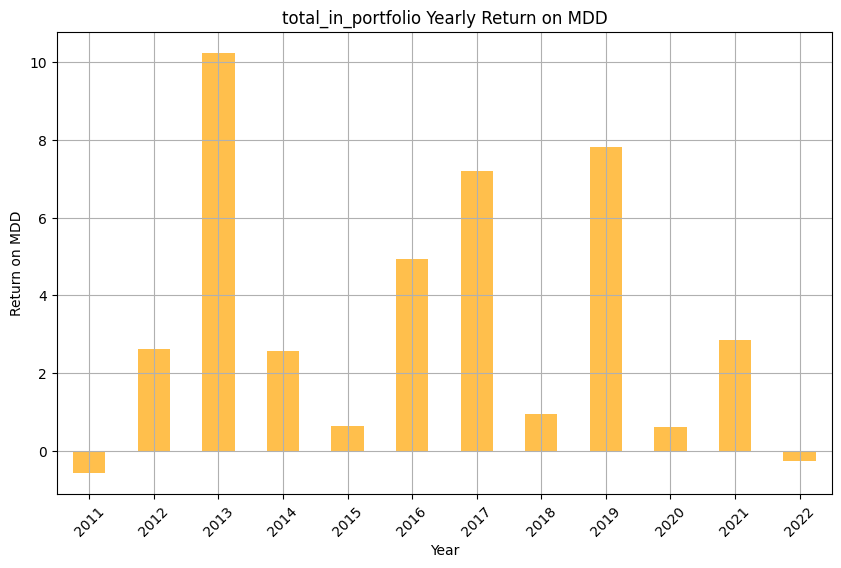

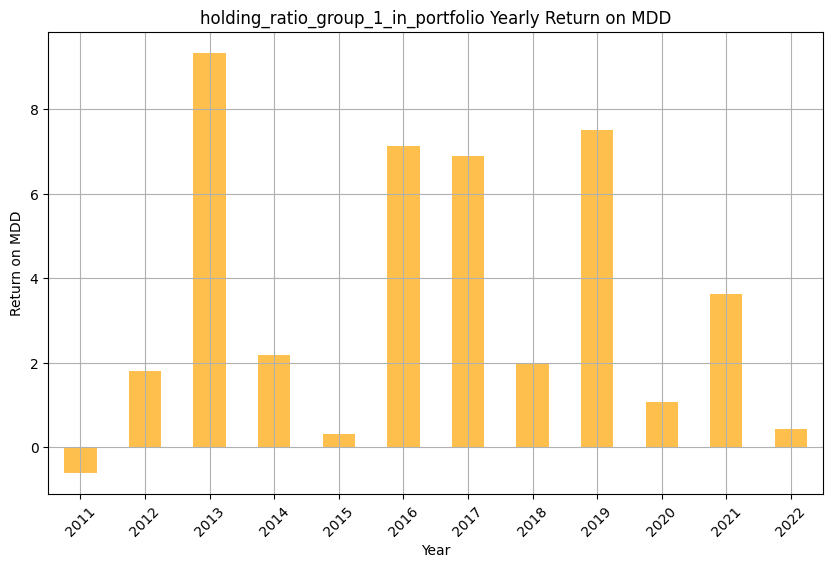

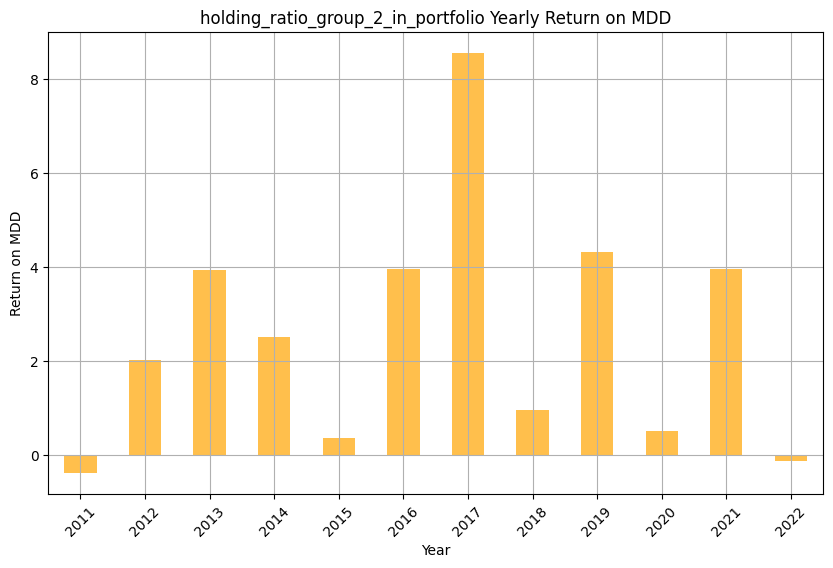

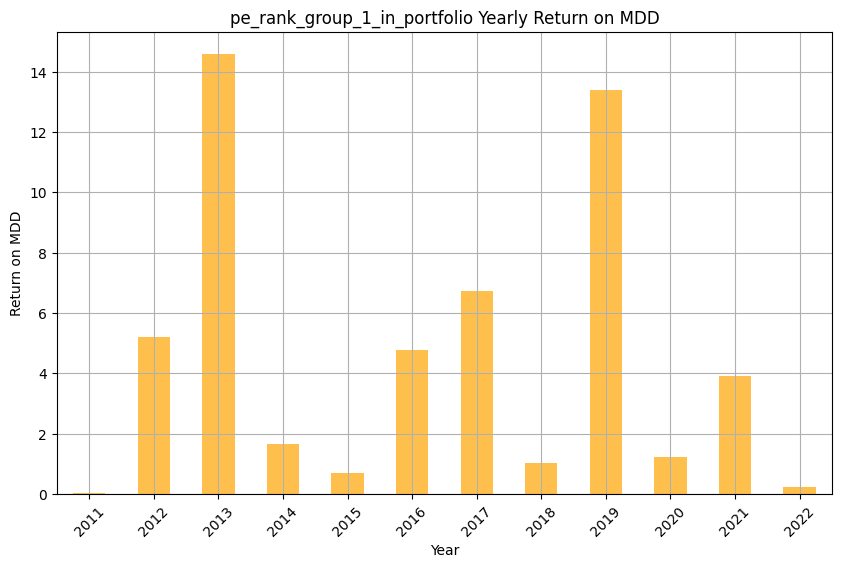

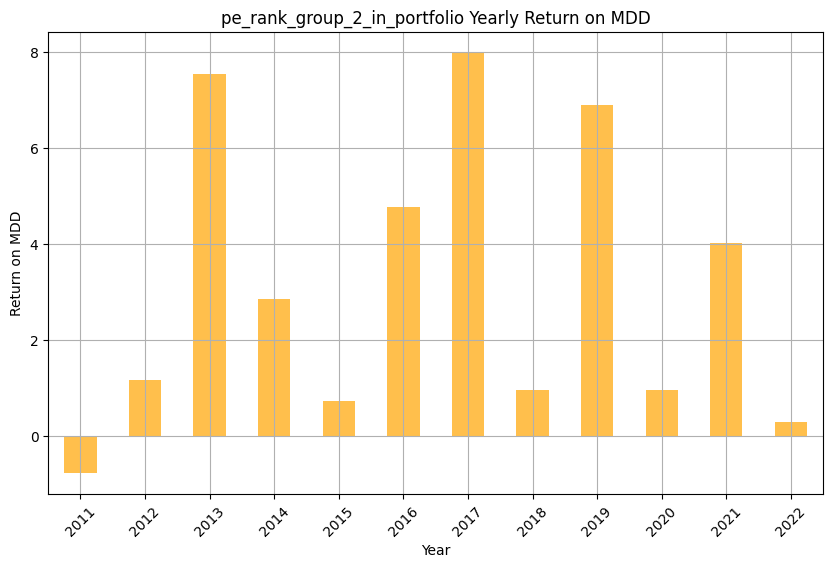

In [21]:
roa_results = {}  # 用於儲存每個組別的 MDD 結果
# 假設 mon_df 已經被定義並且有 datetime 類型的索引
mon_df['Year'] = mon_df.index.year
mon_df['Month'] = mon_df.index.month

for group in group_list:
    # 計算累計回報率
    mon_df[f'Cumulative Return_{group}'] = (1 + mon_df[group]).cumprod()
    
    # 計算每年的最大回撤
    annual_mdd = mon_df.groupby('Year')[f'Cumulative Return_{group}'].apply(calculate_max_drawdown)
    yearly_performance = mon_df.groupby('Year')[group].apply(calculate_annual_return)

    roa = yearly_performance/(-annual_mdd)

        # 繪製每年的最大回撤圖
    plt.figure(figsize=(10, 6))
    roa.plot(kind='bar', color='orange', alpha=0.7)
    plt.title(f'{group} Yearly Return on MDD')
    plt.xlabel('Year')
    plt.ylabel('Return on MDD')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()



In [22]:
for group in group_list:
    
    sharp = cal_sharp(mon_df[group])
    vol = cal_volatility(mon_df[group])
    cum_return, ret, dd, mdd, calmarRatio, winRate, profitFactor, winLossRatio, cagr = performane(mon_df[group])

    print(group)
    print(f'profit: {np.round(cum_return[-1],2)}')
    print(f'return: {np.round(ret,4)*100}%')
    print(f'mdd: {np.round(mdd,4)*100}%')
    print(f'volatility: {np.round(vol,2)*100}%')
    print(f'calmarRatio: {np.round(calmarRatio,2)}')
    print(f'sharpRatio: {np.round(sharp,2)}')
    print(f'winRate: {np.round(winRate,4)*100:.2f}%')
    print(f'profitFactor: {np.round(profitFactor,2)}')
    print(f'winLossRatio: {np.round(winLossRatio,2)}')
    print(f'CAGR: {cagr * 100:.2f}%')
    print("____________________________________________________________")



total_in_portfolio
profit: 8.62
return: 861.8100000000001%
mdd: 26.340000000000003%
volatility: 13.0%
calmarRatio: 0.7
sharpRatio: 1.53
winRate: 59.30%
profitFactor: 1.32
winLossRatio: 0.91
CAGR: 18.44%
____________________________________________________________
holding_ratio_group_1_in_portfolio
profit: 9.72
return: 971.7%
mdd: 23.96%
volatility: 12.0%
calmarRatio: 0.83
sharpRatio: 1.66
winRate: 59.99%
profitFactor: 1.35
winLossRatio: 0.9
CAGR: 19.78%
____________________________________________________________
holding_ratio_group_2_in_portfolio
profit: 6.66
return: 665.71%
mdd: 28.1%
volatility: 14.000000000000002%
calmarRatio: 0.55
sharpRatio: 1.24
winRate: 57.53%
profitFactor: 1.25
winLossRatio: 0.92
CAGR: 15.55%
____________________________________________________________
pe_rank_group_1_in_portfolio
profit: 11.92
return: 1192.1%
mdd: 23.3%
volatility: 12.0%
calmarRatio: 0.95
sharpRatio: 1.79
winRate: 59.44%
profitFactor: 1.38
winLossRatio: 0.94
CAGR: 22.04%
_____________________

/var/folders/04/fpqh7vhx0qn8rtsffnv35m3h0000gn/T/ipykernel_4925/1451482935.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = cum_return[-1]/1
/var/folders/04/fpqh7vhx0qn8rtsffnv35m3h0000gn/T/ipykernel_4925/1451482935.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = (cum_return[-1]-cum_return[0]) **(1/12) -1 # 如果是幾何平均才是這樣算，若是算數平均數要改成相減
/var/folders/04/fpqh7vhx0qn8rtsffnv35m3h0000gn/T/ipykernel_4925/257910671.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acc

In [ ]:
# 畫績效年月圖

import seaborn as sns

monthly_returns = mon_df.groupby(['Year', 'Month']).apply(calculate_annual_return).unstack()
cmap = sns.diverging_palette(150, 10, as_cmap=True)
for group in group_list:
    heatmap_data = monthly_returns[group]
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap=cmap, linewidths=.5)
    plt.title(f'{group} Monthly Returns Heatmap')
    plt.xlabel('Month')
    plt.ylabel('Year')
    plt.show()
for group in group_list:# 計算每年的累積績效
    yearly_performance = mon_df.groupby('Year')[group].apply(calculate_annual_return)
    colors = ['red' if val > 0 else 'green' for val in yearly_performance]

    # 繪製年複利績效圖
    plt.figure(figsize=(10, 6))
    bars = plt.bar(yearly_performance.index, yearly_performance, color=colors, alpha=0.7)
    plt.title(f'{group} Yearly Performance')
    plt.xlabel('Year')
    plt.ylabel('Cumulative Return')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

Sharpe Ratio for 2330: 0.8751318141779403
Max Drawdown for 2330: -0.44799741104313306
Mon Sharpe Ratio for total_in_portfolio: 1.52533051110926
Mon Max Drawdown for total_in_portfolio: -0.26336081081502416


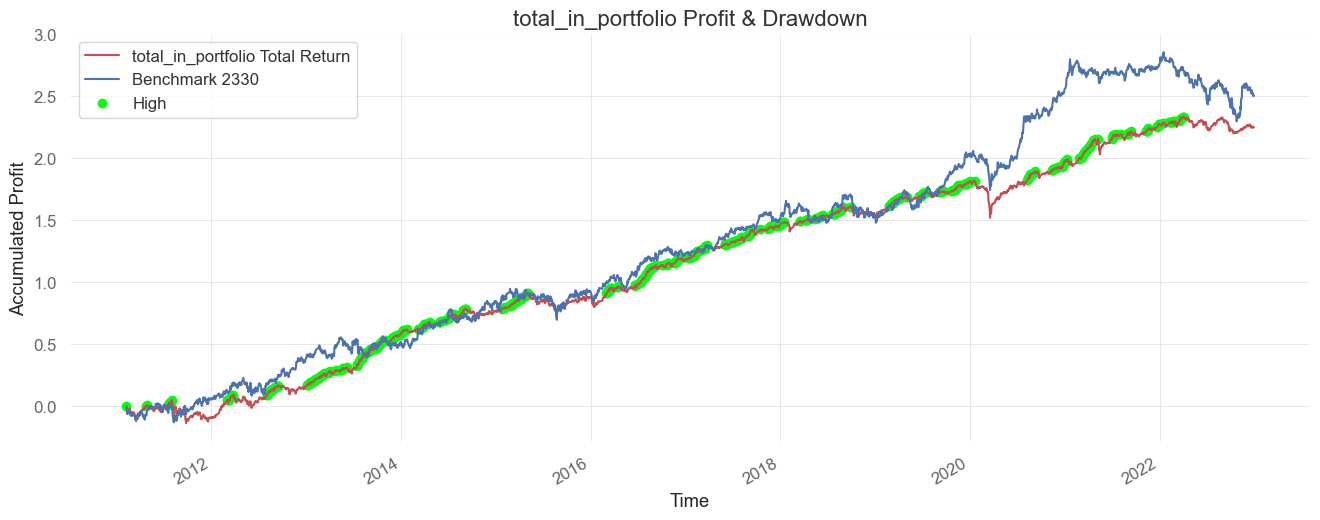

Mon Sharpe Ratio for holding_ratio_group_1_in_portfolio: 1.6564338657089364
Mon Max Drawdown for holding_ratio_group_1_in_portfolio: -0.23958766749649862


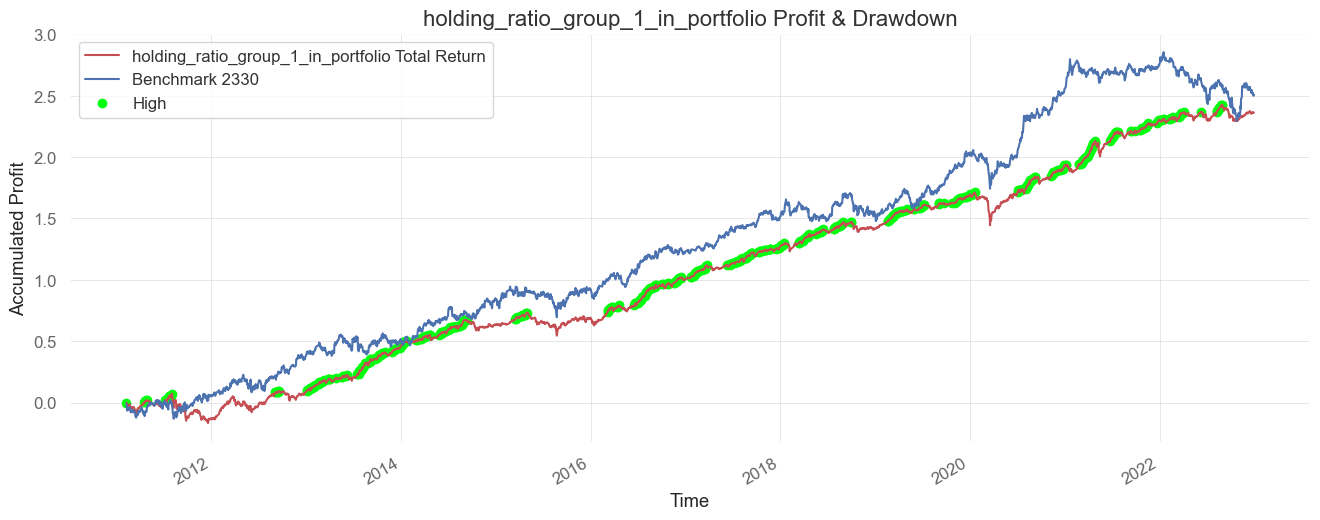

Mon Sharpe Ratio for holding_ratio_group_2_in_portfolio: 1.2384007289528973
Mon Max Drawdown for holding_ratio_group_2_in_portfolio: -0.28098698523750354


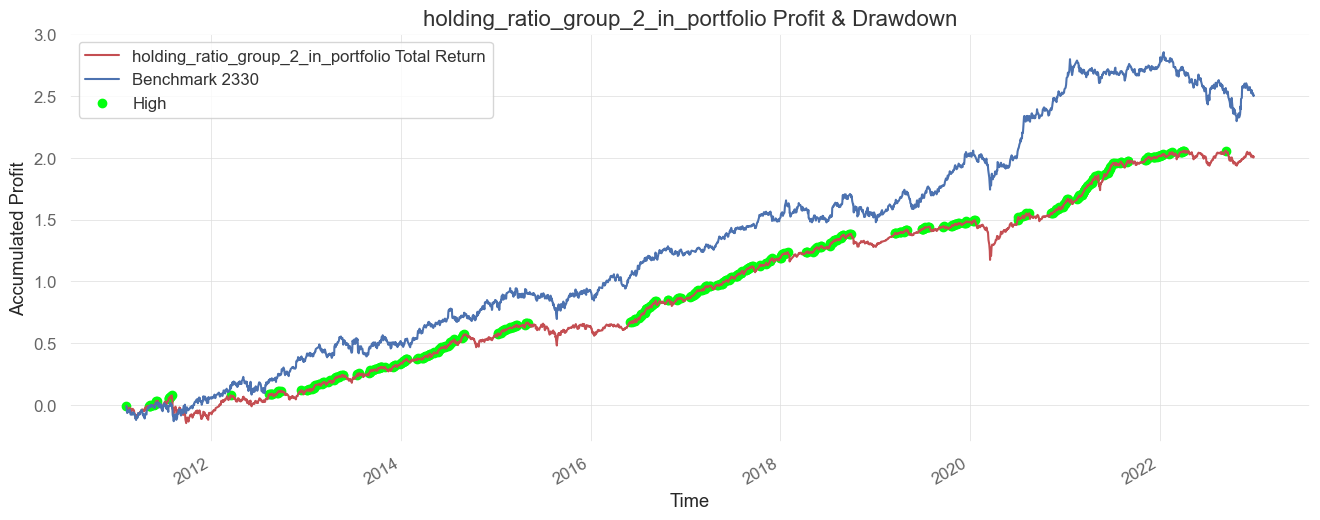

Mon Sharpe Ratio for pe_rank_group_1_in_portfolio: 1.7900668879867923
Mon Max Drawdown for pe_rank_group_1_in_portfolio: -0.23301810690441627


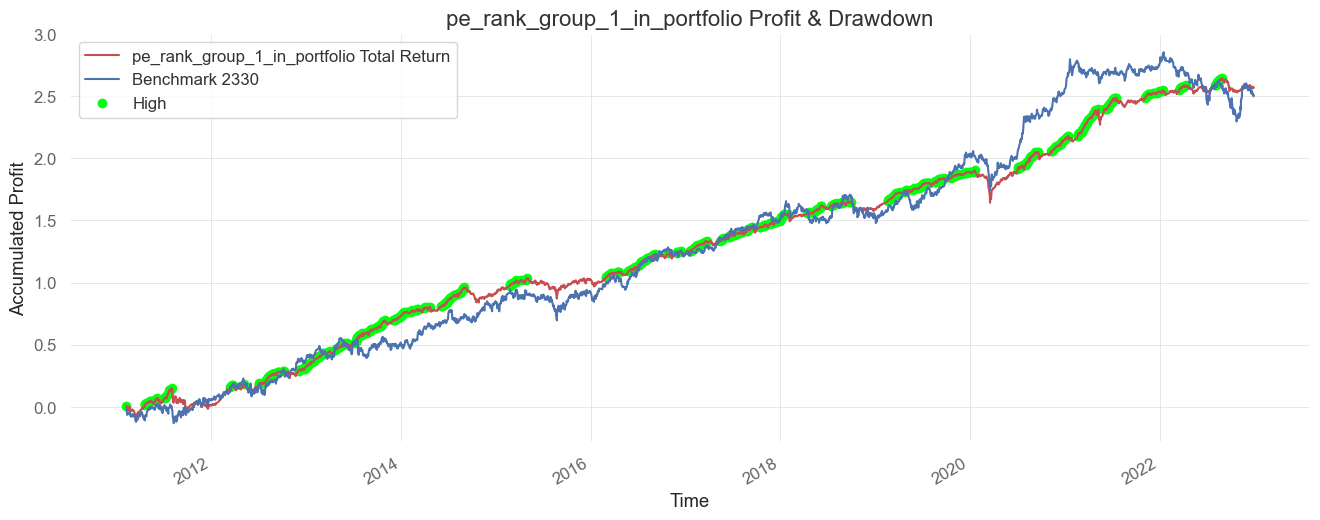

Mon Sharpe Ratio for pe_rank_group_2_in_portfolio: 1.4108235667845943
Mon Max Drawdown for pe_rank_group_2_in_portfolio: -0.28047332083143517


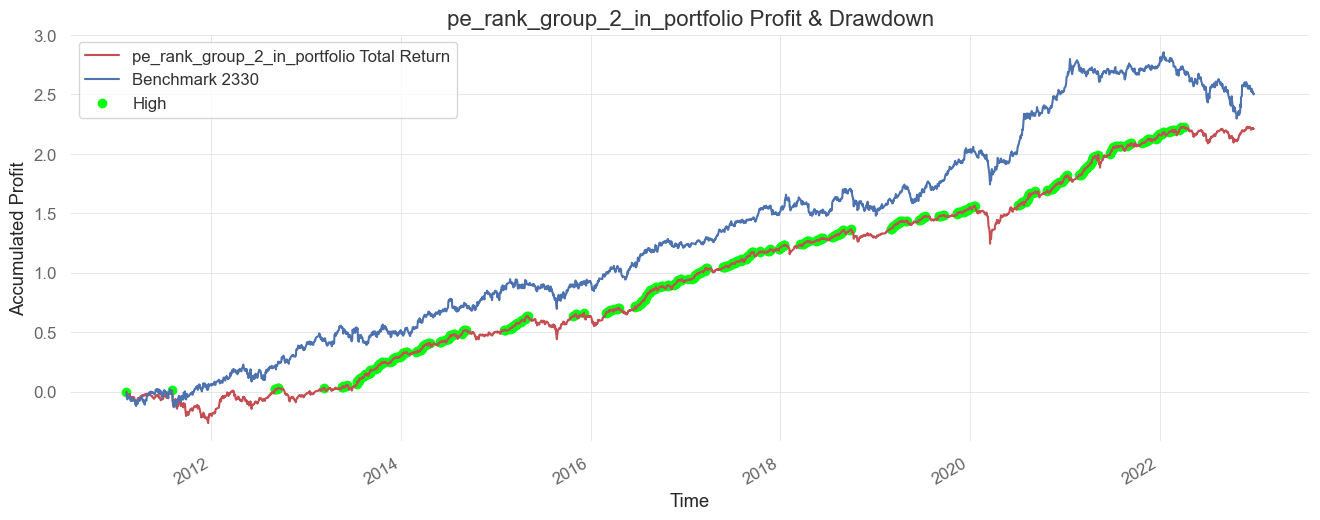

In [27]:
import quantstats as qs

#caculate control group profit
return_list = []
date_list = []

for date in test_return.index:

    return_mean = test_return.loc[date].mean()
    return_list.append(return_mean)
    date_list.append(date)

# create cum_return series as control group
return_series = pd.Series(data=return_list, index=pd.to_datetime(date_list))
cum_return_series = return_series.cumsum()
sharp_ratio_2330 = qs.stats.sharpe(return_series)
mdd_2330 = np.min(qs.stats.to_drawdown_series(return_series))
print(f"Sharpe Ratio for 2330: {sharp_ratio_2330}")
print(f"Max Drawdown for 2330: {mdd_2330}")

# 每個組合的收益
for group in group_list:
    #  月換倉
    mon_group = mon_df[group]
    mon_sharp_ratio = qs.stats.sharpe(mon_group)
    mon_drawdown_series = qs.stats.to_drawdown_series(mon_group)  # series
    mon_mdd = np.min(mon_drawdown_series)
    mon_cumulative_return  = (mon_group).cumsum()  # series
    mon_new_high = mon_cumulative_return[mon_cumulative_return.cummax() == mon_cumulative_return]
    mon_high_index = mon_new_high.index    

    # 季換倉
    #quar_group = quar_df[columns]
    #quar_sharp_ratio = qs.stats.sharpe(quar_group)
    #quar_drawdown_series = qs.stats.to_drawdown_series(quar_group)  # series
    #quar_mdd = np.min(quar_drawdown_series)
    #quar_cumulative_return  = (quar_group).cumsum()  # series
    #quar_new_high = quar_cumulative_return[quar_cumulative_return.cummax() == quar_cumulative_return]
    #quar_high_index = quar_new_high.index

    print(f"Mon Sharpe Ratio for {group}: {mon_sharp_ratio}")
    print(f"Mon Max Drawdown for {group}: {mon_mdd}")


    fig, ax = plt.subplots(figsize=(16, 6))

    # 繪製當前組合的累積收益
    #quar_cumulative_return.plot(label=f'{columns} Total Return', ax=ax, c='r', grid=True)
    mon_cumulative_return.plot(label=f'{group} Total Return', ax=ax, c='r', grid=True)
    
    # 繪製基準的累積收益
    cum_return_series.plot(label="Benchmark 2330", ax=ax, c='b', grid=True)
    
    # 標記高點
    #plt.scatter(quar_high_index, quar_new_high[quar_high_index], c='#02ff0f', label='High')
    plt.scatter(mon_high_index, mon_new_high[mon_high_index], c='#02ff0f', label='High')    
    # 繪製dd區域
    #plt.fill_between(quar_drawdown_series.index, quar_drawdown_series, 0, facecolor='r', label='Drawdown', alpha=0.5)
    
    # 添加圖利標籤
    plt.legend()
    plt.ylabel('Accumulated Profit')
    plt.xlabel('Time')
    plt.title(f'{group} Profit & Drawdown', fontsize=16)
    # 顯示圖表
    plt.show()

/var/folders/04/fpqh7vhx0qn8rtsffnv35m3h0000gn/T/ipykernel_4925/2048892316.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(group, diff[-1])


total_in_portfolio 0.6686666666666645


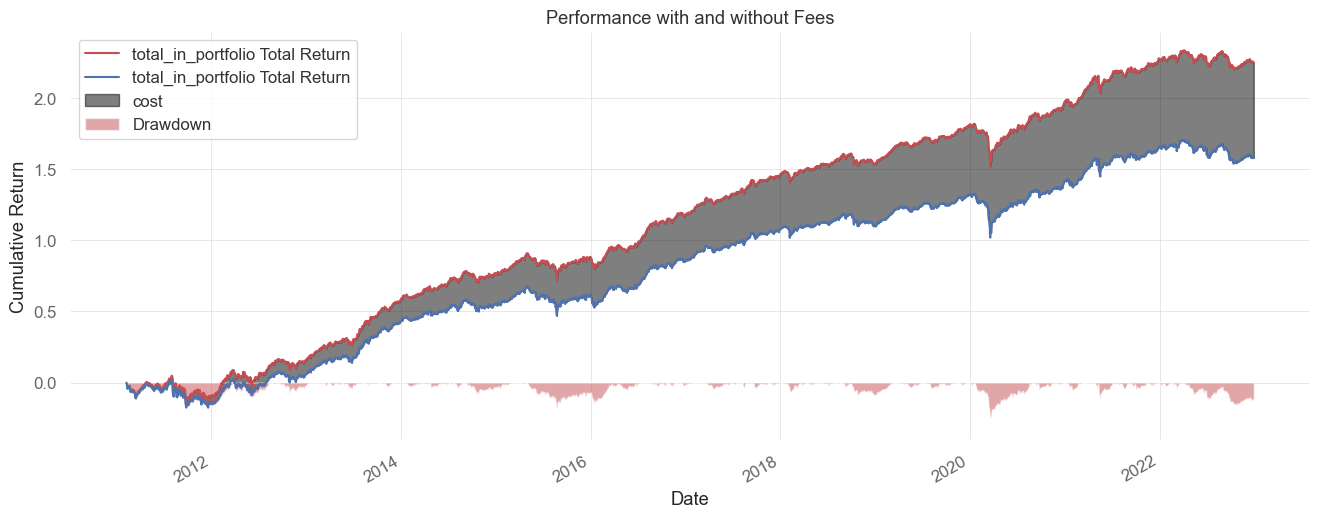

holding_ratio_group_1_in_portfolio 0.603000000000002


/var/folders/04/fpqh7vhx0qn8rtsffnv35m3h0000gn/T/ipykernel_4925/2048892316.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(group, diff[-1])


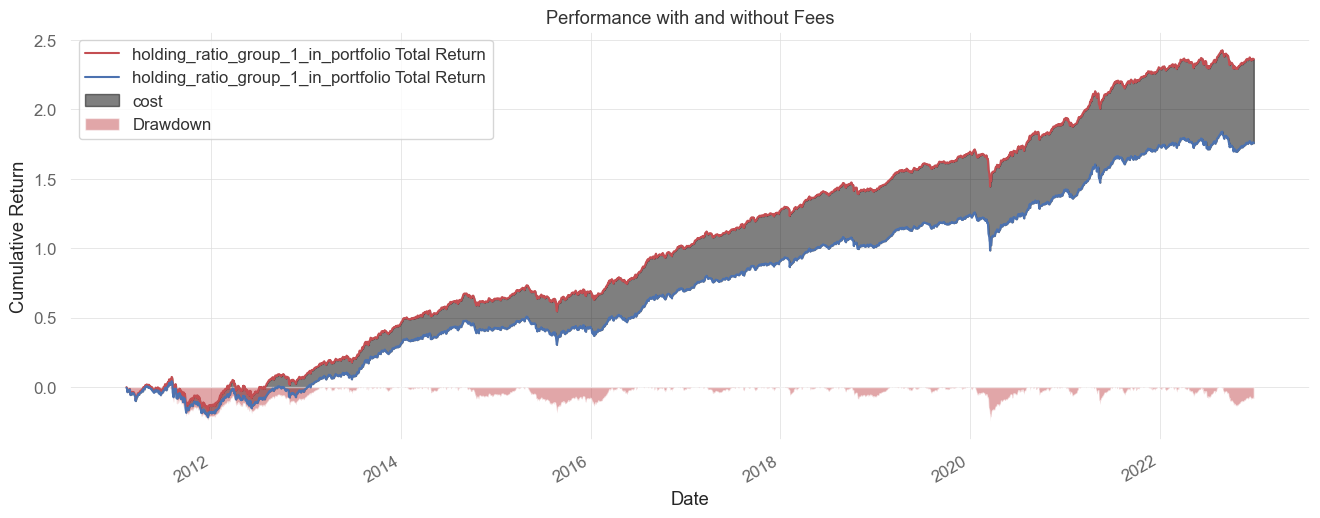

/var/folders/04/fpqh7vhx0qn8rtsffnv35m3h0000gn/T/ipykernel_4925/2048892316.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(group, diff[-1])


holding_ratio_group_2_in_portfolio 0.4280000000000035


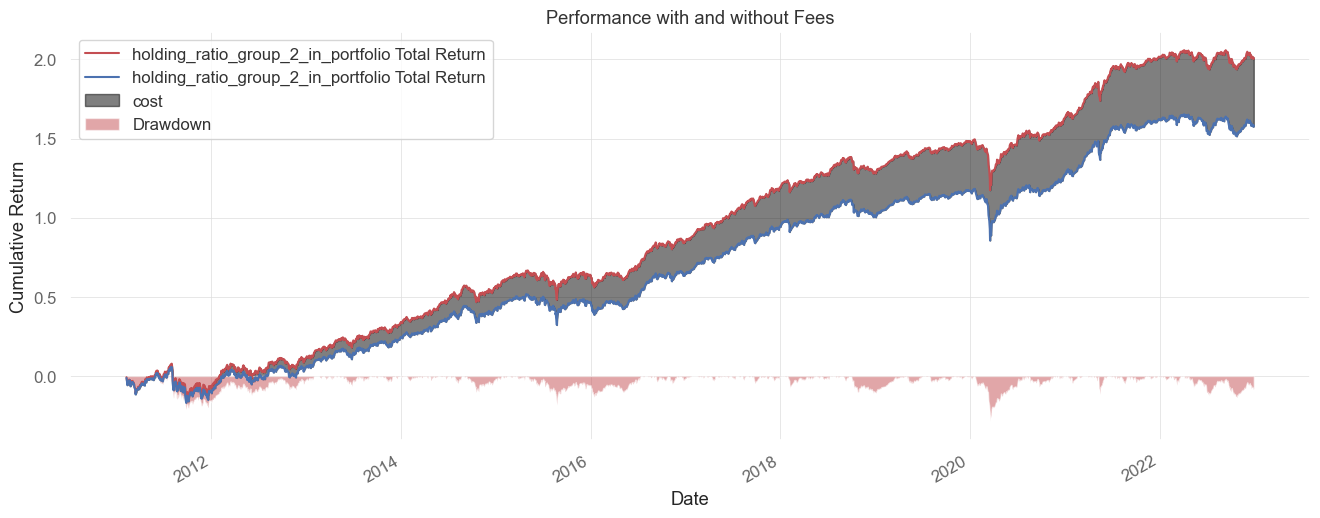

/var/folders/04/fpqh7vhx0qn8rtsffnv35m3h0000gn/T/ipykernel_4925/2048892316.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(group, diff[-1])


pe_rank_group_1_in_portfolio 0.7633333333333381


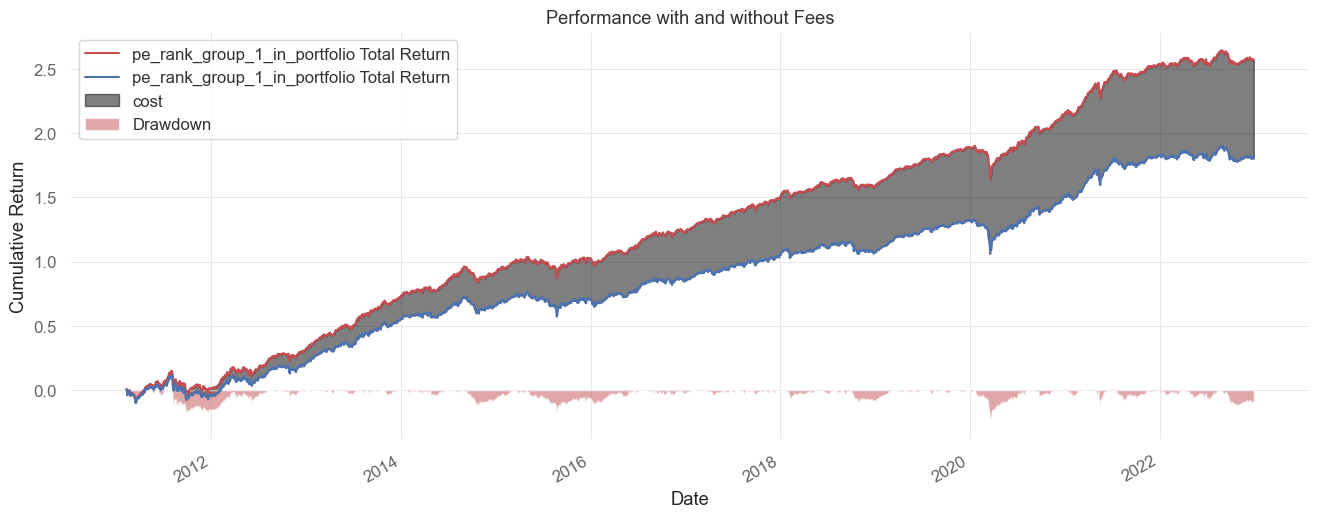

pe_rank_group_2_in_portfolio 0.6306666666666663


/var/folders/04/fpqh7vhx0qn8rtsffnv35m3h0000gn/T/ipykernel_4925/2048892316.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(group, diff[-1])


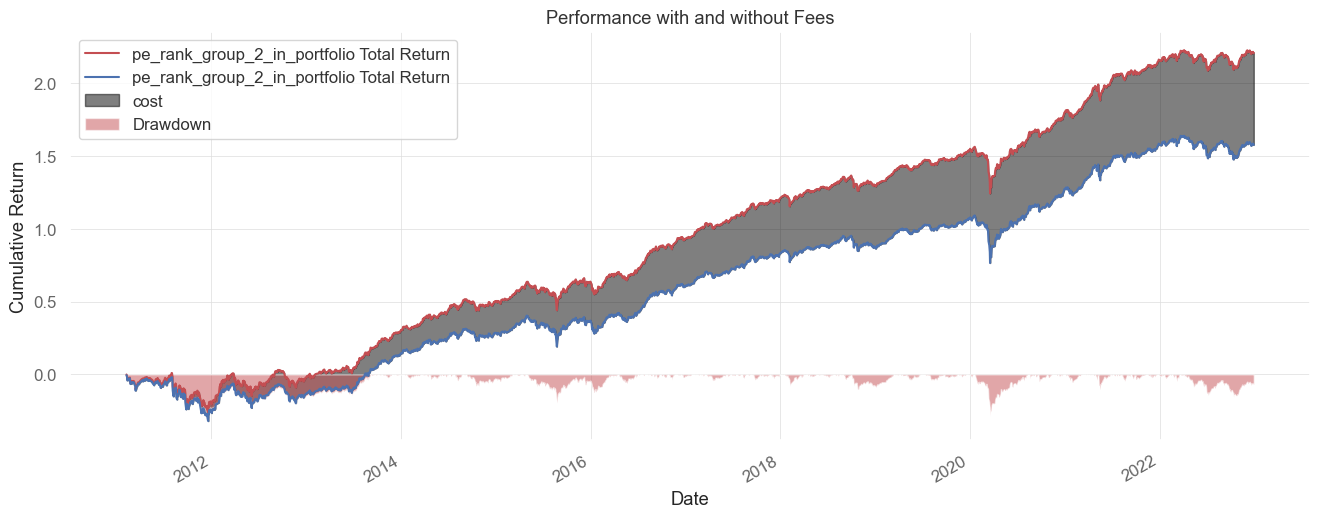

In [28]:
for group in group_list:
    #  月換倉
    mon_group = mon_df[group]
    mon_cumulative_return  = (mon_group).cumsum()  # series
    
    mon_group_fee = mon_df_fee[group]
    mon_drawdown_series_fee = qs.stats.to_drawdown_series(mon_group_fee)  # series
    mon_mdd_fee = np.min(mon_drawdown_series_fee)
    mon_cumulative_return_fee  = (mon_group_fee).cumsum()  # series

    diff = mon_cumulative_return - mon_cumulative_return_fee
    print(group, diff[-1])
    fig, ax = plt.subplots(figsize=(16, 6))
    mon_cumulative_return.plot(label=f'{group} Total Return', ax=ax, c='r', grid=True)
    mon_cumulative_return_fee.plot(label=f'{group} Total Return', ax=ax, c='b', grid=True)
    plt.fill_between(mon_cumulative_return_fee.index, mon_cumulative_return_fee, mon_cumulative_return, color = 'black', label = 'cost', alpha = 0.5)
    plt.fill_between(mon_drawdown_series_fee.index, mon_drawdown_series_fee, 0, facecolor='r', label='Drawdown', alpha=0.5)

    plt.title('Performance with and without Fees')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()

In [30]:
mon_df_fee['pe_rank_group_1_in_portfolio'].to_csv('/Users/tzuyuan/DATA/pe_rank_group_1_in_portfolio.csv')